<a href="https://colab.research.google.com/github/Kazuhiko-Miyata/DCGAN_MNIST_generate/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **DCGANの対応**
DCGAN（Deep Convolutional Generative Adversarial Networks）は、生成器と識別器に畳み込みニューラルネットワークを利用した、オリジナルGANの発展版。

DCGANはCNNのおかげで、オリジナルGANに比べて画像が鮮明になり、安定した学習が可能になった。DCGANの作成には試行錯誤を要し、作成の指針は論文によると次の通り。


<br><br>
1.   識別機にストライド２の畳み込み層、生成器にストライド２の転置畳み込み層を利用
2.   全結合層は利用しない
3.   出力層と生成器の入力層を除き、バッチ正規化を利用
4.   生成器は活性化関数にReLUを利用し、出力層はtanh関数を利用
5.   識別器はすべての活性化関数にLeaky ReLUを利用
6.   本物画像を-1～1の値域で正規化

<br><br>指針1.によると、識別器は畳み込み層を使用する。識別器の畳み込み層は、Aの3×3カーネルがストライド2で移動する。また、パティング1の場合は点線のように画像の周囲が外側へ1だけ広がる。結果、Bの5×5画像を畳み込み層に入力するとCの3×3画像を出力し、画像サイズが縮小する。







<img src="https://drive.google.com/uc?id=1XfxGckrKO3hgcAlE_qghhGl4VeHl3HVg" width="80%">

生成器に使用する転置畳み込み層もDの3×3カーネルがストライド２で移動する。またパディングして画像の周囲を外側へ１だけ広げる。結果Eの3×3画像を転置畳み込み層に入力するとFの5×5画像を出力し、画像サイズが拡大する。

<img src="https://drive.google.com/uc?id=1Ff5c_Q92lbPHNWBq-ilupYmHKYRi4O8n" width="80%">

指針４によると、生成器の出力層にtanh関数を使用する。tanh関数は-1～1の値域であるため、生成画像のが措置は-1～1になる。識別器は本物画像と生成画像の真贋を判定するため、が措置の値域をそろえる必要がある。そのため、指針6で本物画像のが画素値を-1～1の値域に変換する。

<br><br>指針5によると、識別器の活性化関数にLeaky reLUを使用する。生成器は識別器を経由して、誤差を逆伝播する。そのため値がマイナスでも勾配消失しないLeaky ReLUを使用する。

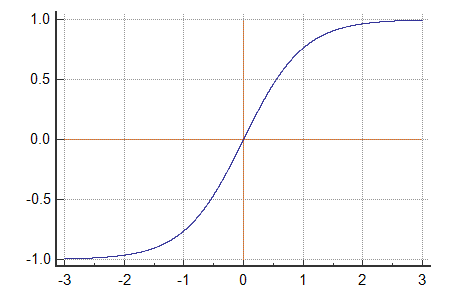

## **生成器のネットワーク（白黒）画像**
今回のDCGANおよび次の節のConditionalGANはデータセットMNISTを用いて数字画像を生成する。ストライド２つの転置畳み込み層で画像サイズを拡大する。生成器の活性化関数はReLUを使用するが、出力層だけは活性化関数にtanh関数を利用し、バッチ正規化を使用しない点に注意。

<img src="https://drive.google.com/uc?id=1YCvRvmuEBuoBpHN3cf7EYv-b2sRA6oQr" width="40%">

まず、生成器に入力するノイズ$z$を用意する。ノイズは1次元ベクトルだが、生成器はCNNのため、ノイズを畳み込み層が計算できるTensor（配列）に変換する必要がある。PyTorchの場合、畳み込みそうは4次元Tensorを入力する仕様。

<br><br>**Tensorの形状=(バッチサイズ、チャンネル、高さ、幅)**

<br><br>1画像の生成にしようするノイズベクトルの次元数は100、ネットワークにB個のノイズ$z$を一度に入力する場合、Tensorの形状は次のようになる。

<br><br>**ノイズ$z$のTensorの形状=(B,100, 1, 1)**

<br><br>生成機の中の転置畳み込み層は、ノイズのTensorを画像のTensorに変換する。結果、生成器はB個のサイズ２８×２８の画像を出力する。画像は白黒につきチャンネル数は１。
<br>layer0の中には転置畳み込み層、バッチ正規化、ReLUの活性化関数がある。転置畳み込み層は画像サイズを拡大するので、layer0のTensorは（B、５１２、３、３）に変換される。続けてlayer1、layer2でもlayer0と同じ処理を実行し、Tensorは（B、１２８、１４、１４）になる。最後のlayer3は転置畳み込み層とTanhの構成で、支出力チャンネル数は白黒画像のため1になる。その結果、Tensorは（B、１、２８、２８）に変換され、サイズ２８×２８の白黒画像がB個ぶん生成できる。これで、バッチサイズB個の画像を生成できる。

<br><br>**▽生成器GのクラスGenerator**

```
class Generator(nn.Module):
    """
    生成器Gのクラス
    """
    def __init__(self, nz=100, nch_g=128, nch=1):
        """
        :param nz: 入力ベクトルの次元
        :param nch_g: 最終層の入力チャンネル数
        :param nch: 出力画像のチャンネル数
        """
        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layer = nn.ModuleDict({
            "layer0":nn.Sequential(
                nn.ConvTranspose2d(nz, nch_g * 4, 3, 1, 0),
                                                # 転置畳み込み
                nn.BatchNorm2d(nch_g * 4),   # バッチノーマライゼーション
                nn.ReLU()                      # ReLU
            ),    # (B, nz, 1, 1) -> (B, nch_g*4, 3, 3)
            "layer1":nn.Sequential(
                nn.ConvTranspose2d(nch_g * 4, nch_g *2, 3, 2, 0),
                nn.BatchNorm2d(nch_g * 2),
                nn.ReLU()
            ),   # (B, nch_g*4, 3, 3) -> (B, nch_g*2, 7, 7)
            "layer2":nn.Sequential(
                nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                nn.BatchNorm2d(nch_g),
                nn.ReLU()
            ),   # (B, nch_g*2, 7, 7) -> (B, nch_g, 14, 14)
            "layer3":nn.Sequential(
                nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                nn.Tanh()
            ),   # (B, nch_g, 14, 14) -> (B, nch, 28, 28)
        })

    def forward(self, z):
        """
        順方向の演算
        :param z: 入力ベクトル
        :return: 生成画像
        """
        for layer in self.layer.values():  # self.layerの各層で演算を行う
            z = layer(z)
        return z
```



## **識別器のネットワーク（白黒画像）**
識別器は画像の真贋を識別するネットワーク。識別器は本物と生成どちらかの画像が入力され、本物である確立を出力する。識別器はストライド２の畳み込み層で画像を縮小する。活性化関数にLeaky ReLUを利用し、入力層と出力そうはバッチ正規化を使用しないことに注意。

<img src="https://drive.google.com/uc?id=1QAA9YGBpRE3rka9Kck7tcBGfMOxWy_WA" width="40%">

識別器はB個の本物画像または生成画像を識別する。画像は白黒のためチャンネル数は１、画像サイズは２８×２８のため、Tensorは（B、１、２８、２８）になる。layer0の中には畳み込み層、Leaky ReLUがあり、Tensorは（B、１２８、１４、１４）に変換される。続くlayer1とlayer２の中には畳み込み層、バッチ正規化、Leaky ReLUがあり、画像サイズは段階的に小さくなる。layer3は畳み込み層とSigmoid関数で、B個の識別信号（B、１、１、１）のTensorに変換される。識別器の最後にaqueezeメソッドがあり、不要な次元は削除され、識別器はB個の識別信号（スカラー）を出力する。

<br><br>**▽識別器DのクラスDiscriminator**


```
class Discriminator(nn.Module):
    """
    識別器Dのクラス
    """
    def __init__(self, nch=1, nch_d=128):
        """
        :param nch: 入力画像のチャンネル数
        :param nch_d: 先頭層の出力チャンネル数
        """
        # ニューラルネットワークの構造を定義する
        super(Discriminator, self).__init__()

        self.layer = nn.ModuleDict({
            "layer0":nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1), # 畳み込み
                nn.LeakyReLU(negative_slope=0.2),   # Leaky ReLU関数
            ),    # (B, nch, 28, 28) -> (B, nch_d, 14, 14)
            "layer1":nn.Sequential(
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 2),
                nn.LeakyReLU(negative_slope=0.2)
            ),   # (B,nch_d, 14, 14) -> (B, nch_d*2, 7, 7)
            "layer2":nn.Sequential(
                nn.Conv2d(nch_d * 2, nch_d * 4, 3, 2, 0),
                nn.BatchNorm2d(nch_d * 4),
                nn.LeakyReLU(negative_slope=0.2)
            ),   # (B, nch_d*2, 7, 7) -> (B, nch_d*4, 3, 3)
            "layer3":nn.Sequential(
                nn.Conv2d(nch_d * 4, 1, 3, 1, 0),
                nn.Sigmoid(). # Sigmoid関数
            ),   # (B, nch_d*4, 3, 3) -> (B, 1, 1,1)
        })

    def forward(self, x):
        """
        順方向の演算
        :param x: 本物画像あるいは生成画像
        :return: 識別信号
        """
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze() # Tensorの形状を（B）に変更して戻り値とする         
```



## **識別器の損失関数**
GANの損失関数は以下の式になる。損失関数は識別器と生成器の学習に使用する。

<br><br>$$
\min_{G} \max_{D}L(D,G)=\mathbb{E}_{x\sim{pdata(x)}}[\log{D(x)}+\mathbb{E}_{z\sim{p_z(z)}}[\log(1-D(G(z)))]
$$

<br><br>損失関数$L(D,G)$は識別器Dが最大化、生成器Gが最小化する。GANは識別器と生成器で交互に学習するため、損失関数を識別器の損失関数$L(D)$と生成器の損失関数$L(G)$の2つに分けて考える。なお、損失関数$L(D)$は損失関数$L(D,G)$の符号を逆にして、識別器Dの最小値問題と考える。

<br><br>$$
L(D)=-\mathbb{E}_{x\sim{pdata(x)}}[\log D(x)]-\mathbb{E}_{z\sim{pz}(z)}[\log(1-D(G(z)))]
$$

<br><br>識別器Dは本物画像と生成画像の２種類の入力があり、損失関数$L(D)$は本物画像の損失と生成画像の損失の合計となる。本物画像の入力時は識別信号$D(x)$を出力し、生成画像の入力時は識別信号$D(G(z))$を出力する。
<br>第１項目は本物画像の損失でデータ分布$_{pdata}(x)$から画像$x$を取り出し、識別器の識別信号が$D(x)=1$のときの損失は0になる。第２項はノイズの確立分布$_{p_z}(x)$からノイズ$z$と取り出し、識別器の識別信号が$D(G(z))=0$のとき損失は0になる。つまり損失関数$L(D)$は、識別器が本物画像と生成画像を正しく分類した時に損失が0になり、誤分類した時に損失が発生する。
<br>識別器Dの損失関数は識別器の2クラス分類と考えると、バイナリークロスエントロピーで定式化できる、バイナリークロスエントロピーは負の尤度関数を用いて最小値を計算する。正解ラベルは$y=1$、偽物$y=0$の２値になる。

<br><br>$$
J^D=-y\log D(x)-(1-y) \log(1-D(G(z)))
$$

<br><br>本物画像を識別器に入力するとき、正解ラベルは$y=1$となり、第１項は識別信号$D(x)$の誤差計算に使用する。また、生成画像を入力するとき、正解ラベルは$y=0$となり、第２項は識別信号$D(G(z))$の誤差計算に利用する。識別信号$D$と$D(G(z))$は識別器の最終層のSigmoid関数があるため0〜1の値域になる。

## **生成機の損失関数**
損失関数$L(G)$は損失関数$L(D,G)$の最小値を計算する。

<br><br>$$
\min_{G} \max_{D}L(D,G)=\mathbb{E}_{x\sim{pdata(x)}}[\log D(x)]+\mathbb{E}_{z\sim{p_z(z)}}[\log(1-D(G(z)))]
$$

<br><br>生成器Gはノイズの確立分布$_{p_z}(z)$からノイズ$z$を取り出すため、損失関数$L(G)$は損失関数$L(D, G)$の第２項だけ使用する。第１項はノイズに対して定数になり、学習する際にお勾配は0なので無視する。

<br><br>$$
L(G)=\mathbb{E}_{z\sim_{p_z(z)}}[\log(1-D(G(z)))]
$$

<br><br>生成器は、識別器を本物だとだますことができたら、識別信号$D(G(z))=1$となる。このとき、損失関数$L(G)$はマイナス無限大になり、損失は最小化する。逆にだますことができなかったら、識別信号$D(G(z))=0$となり、損失関数は0で最大化する。
<br>しかし損失関数$L(G)$はオリジナルGANに説明がある通り、$D(G(z))=0$付近の勾配が小さく、生成機の学習が進まないという問題がある。そこで、損失関数$L(G)$を次のように書き換え、勾配消失を防ぐ。

<br><br>$$
L(G)=-\mathbb{E}_{z\sim{p_z}(z)}[\log(1-D(G(z)))]
$$

<br><br>書き換えにより、$D(G(z))=0$付近に大きな勾配が発生し、生成機の学習が可能になる。また、$D(G(z))=1$で損失は0になる。

<img src="https://drive.google.com/uc?id=1o2X-cRoLnV2RLVRqiwPK9cHycb2zkC3t" width="60%">

生成器mぽ識別器と同様にバイナリークロスエントロピーの損失関数で定式化できる。ただし、生成器と識別器の符号は逆になる。

<br><br>$$
J^G=-J^D
$$

<br>$$
J^G=y\log D(x)+(1-y)\log(1-D(G(z)))
$$

<br><br>バイナリークロスエントロピーでは、正解は$y=1$と$y=0$の２値だが、生成機は$y=0$の生成画像のクラスだけを使用し、第２項が残る。

<br><br>$$
J^G=\log(1-D(G(z)))
$$

<br>さらに$L(G)$と同じく、損失関数$J^G$は次の用に書き直せる。

<br><br>$$
J^G=-\log D(G(z))
$$

<br><br>この式はバイナリークロスエントロピーの$J^G=-y\log D(G(z))$の$y=1$の指揮と同じで、正解ラベルは$y=0$ではなく$y=1$と考える。また識別信号$D(G(z))=1$、つまり生成器が識別器を本物だとだましたとき、損失関数$J^G$は0になり最小化する。

## **DCGANの実装**
生成器のネットワークを定義する。printでネットワークの中を確認できる。生成器は転置叩き込みそう、バッチ正規化、ReLUで構成される。出力層はTanh()で-1～1の値域を取る。



```
# 生成器G ランダムベクトルから生成画像を生成する
netG = Generator(nz=nz, nch_g=nch_g).to(device)
netG.apply(weights_init)  # weights_init関数で初期化
print(netG)
```

<br><br>次に識別器のネットワークを定義する。識別器は畳み込み層、バッチ正規化、Leaky ReLUで構成される。出力層はSigmoid（）で、出力値は0～1の値域になる。


```
# 識別器D 画像が本物画像か生成画像化を識別する
netD = Discriminator(nch_d=nch_d).to(device)
netD.apply(weights_init)
print(netD)
```

<br><br>MNISTは0～255のが措置を敦賀、torchvisionに格納されているMNISTのが措置は0～1に正規化されている。このが措置を平均0.5/分散0.5で正規化し、-1（黒）～1（白）の値域に変換する。この変換は、生成器の出力値が-1～1の値域なので、本物画像の画素値を生成画像の画素値-1～1にそろえるための対応。dataloaderは1回の学習のイテレーションで取り出すデータ数を設定する。
<br>バッチサイズの数を指定するbatch_sizeに50を設定し、1回の学習で50個の画像を取り出す。


```
# MNISTの訓練データセットを読み込む
dataset = dset.MNIST(root'./mnist_root', download=True,
train=True, transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,),(0.5)) ]))
# 訓練データをセットしたデータローダーを作成する
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=int(workers))
```

<br><br>損失関数は、識別器Dの識別信号と正解ラベルが入力になる。識別器の出力層にSigmoid関数を設定したので、損失関数criterionはSigmoid関数を省いたクラスnn.BCELoss()を使用する。
<br>1エポックごとに確認用の画像を生成できるよう、固定用のノイズベクトルを50個作成する。なお、ノイズは一様分布よりも標準正規分布からサンプリングする。


```
criterion = nn.BCELoss()   # バイナリークロスエントロピー

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# optimizerのセットアップ
optimizerD = optim.Adam(netD.para,eters(), ly=lr, betas=(deta1, 0.999),
              weight_decay=1e-5) # 識別器D用
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999),
              weight_decay=1e-5) # 生成器G用
```
識別器Dは本物画像と生成画像のそれぞれについて本物か偽物かを識別するので、識別器の損失は本物画像の損失と生成画像の損失の合計になる。

<br><br>$$
J^D=-y\log D(x)-(1-y)\log(1-D(G(z)))
$$

<br><br>本物画像の損失を求めるため、本物画像real_imagesを識別器netDに入力し、識別信号outputと正解ラベルreal_targetの1（本物）を比較し、errD_realを計算する。生成画像については、バッチサイズぶんのノイズnoiseを生成器netGに入力してfake_imageを生成し、これを識別器netDに入力して、識別信号outputを計算する。続けて、生成画像の損失を求めるため、識別信号outputと正解ラベルfake_targetの0（偽物）を比較し、errD_fakeを計算する。識別器の損失はerrD_realとerrD_fakeの合計になるので、損失を逆伝播して、識別器DのパラメータをoptimizerD.step()で更新する。このとき、生成器のパラメータは更新しないことに注意。


```
# 学習のループ
for epoch in range(n_epoch):
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)
        samole_size = real_image.size(0)

        # 標準正規分布からノイズを生成
        noise = torch.randn(sample_size, nz, 1, 1, device=device)
        # 本物画像に対する識別信号の目標値[1]
        real_target = torch.full((sample_size,), 1., device=device)
        # 生成画像に対する識別信号の目標値[0]
        fake_target = torch.full((sample_size,), 0., device=device)

        ##################################
        # 識別器Dの更新
        ##################################
        netD.zero_grad()   # 勾配の初期化

        output = netD(real_image) # 識別器Dで本物画像に対する識別信号を出力
        errD_real = criterion(output, real_target) # 本物画像に対する識別信号の損失値
        D_x = output.mean().item() # 本物画像の識別信号の平均

        fake_image = netG(noise) # 生成器Gでノイズから生成画像を生成

        output = netD(fake_image.detach()) # 識別器Dで生成画像に対する識別信号を出力
        errD_fake = criterion(output, fake_target) # 生成画像に対する識別信号の損失値
        D_G_z1 = output.mean().item.() # 生成画像の識別信号の平均

        errD = errD_real + errD_fake # 識別器Dの全体の損失
        errD.backwqard() # 誤差逆伝播
        optimizerD.step() # Dのパラメータを更新
```

<br><br>生成器Gは生成画像の損失だけ必要なので、生成器の損失は次の式になる。

<br><br>$$
J^G=-\log D(G(z))
$$

<br><br>この時の識別器Dは直前のパラメータ更新optimizerD.step()で少し学習が進んでいく。今回は識別器のパラメータを固定して、生成器のパラメータを更新する。
<br>識別器netDにfake_imageを入力して、識別信号outputを計算する。生成画像の損失を求めるため、sikibetusinngou
outputと本物の正解ラブrreal_targetの１を比較し、errGを計算する。損失errGを誤差逆伝播して、生成器GのパラメータをoptimizerG.step()で更新する。


```
    ##########################
    # 生成器Gの更新
    ##########################
    netG.zero_grad()  # 勾配の初期化

    output = netD(fake_image)  # 更新した識別器Dで改めて生成画像に対する識別信号を出力
    errG = criterion(output, real_target)  # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は[1]
    errG.backward()  # 誤差逆伝播
    D_G_z2 = output.mean().item()  # 更新した識別器による生成画像の識別信号の平均

    optimizerG.step()  # Gのパラメータ更新
```

<br><br>ログはdisplay_intervalの間隔で表示して、1エポックごとに生成画像を保存する。生成画像は1エポックごとの学習状況がわかるよう、学習ループの外で事前に作成した固定ノイズを利用する。
<br>ログにはLoss_D、Loss_Gに加えて、D(x)、識別器$D(G(z))$、生成器の$D(G(z))$の3つが表示される。$D(x)$、識別器の$D(G(z))$は識別器Dに使用する識別信号の平均値で、Loss_DはD(x)が1、識別器のD(G(z))が0に近いほど低下する。一方Loss_Gは生成器のD(G(z))が1に近いほど、低下する。


```
    if itr % display_interval == 0:
        print('[{}/{}][{}/{}] Loss D:{:.3f} Loss_G:{:.3f} D(x):{:.3f} D(G(z)):{:.3f}/{:.3f}
            .format(epoch + 1, n_epoch,
                itr +1, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1,
        D_G_z2))

    if epoch == 0 and itr == 0:   # 初回に本物画像を保存する
        vutils.save_image(real_image, '{}/real_samples.png'.format(outf),
        normalize=True, nrow=8)

    ##########################
     # 確認用画像の生成
    ##########################
    fale_image = netG(fixed_noise) # 1エポック終了後とに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch +1),
        normalize=True, nrow=8)
```












識別器の識別信号$D(x)$は0.8前後で振動し、識別器の$D(G(z))$を示す「/」前は0.2前後で振動している。生成器の$D(G(z))$を示す「/」の後は識別器のパラメータ更新に伴い、識別器の$D(G(z))$より0に近い値になっていることがわかる。逆に、次イテレーションの識別器の$D(G(z))$は、生成器のパラメータ更新に伴い、生成器の$D(G(z))$より1に近づいていることがわかる。
<br>最後に、本物画像と生成画像の比較をする。VAEの生成画像は全体的にぼやけていたが、GANの生成画像は本物画像と見分けがつかないほど鮮明になる。

In [ ]:
import torch
import torchvision
import os
import random
import numpy as np
import matplotlib

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary

In [ ]:
# 設定
workers = 2
batch_size = 50
nz = 100
nch_g = 128
nch_d = 128
n_epoch = 10
lr = 0.0002
beta1 = 0.5
outf = './result_3_2-DCGAN'
display_interval = 600

# 保存先ディレクトリを作成
try:
    os.makedirs(outf, exist_ok=True)
except OSError as error:
    print(error)
    pass

# 乱数のシードを固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
# MNISTのデータセットを読み込む
dataset = dset.MNIST(root='./mnist_root', download=True, train=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,), (0.5))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 168744236.59it/s]

Extracting ./mnist_root/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_root/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 53599864.52it/s]


Extracting ./mnist_root/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_root/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42157216.68it/s]


Extracting ./mnist_root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_root/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23091550.02it/s]


Extracting ./mnist_root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_root/MNIST/raw



In [ ]:
# 画像配列の確認
dataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
# 画像の値域の確認
dataset[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [ ]:
# 訓練データをセットしたデータローダーを作成する
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(workers))

# 学習に使用するデバイスを得る
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [1]:
class Generator(nn.Module):
      """
      生成器のクラス
      """
      def __init__(self, nz=100, nch_g=128, nch=1):
          """
          :param nz: 入力ベクトルｚの次元
          :param nch_g: 最終層の入力チャンネル数
          :param nch: 出力画像のチャネル数
          """
          super(Generator, self).__init__()

          # ニューラルネットワークの構造を定義する
          self.layers = nn.ModuleDict({
            'layer0':nn.Sequential(
                nn.ConvTranspose2d(nz, nch_g * 4, 3, 1, 0),
                nn.BatchNorm2d(nch_g *4),
                nn.ReLU()
            ), # (B, nz, 1, 1) -> (B, nch_g*4, 3, 3)
            "layer1": nn.Sequential(
                nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 3, 2, 0),
                nn.BatchNorm2d(nch_g* 2),
                nn.ReLU()
            ), # (B, nch_g*4, 3, 3) -> (B, nch_g*2, 7, 7)
            "layer2": nn.Sequential(
                nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                nn.ReLU()
            ),  # (B, nch_g*2, 7, 7) -> (B, nch_g, 14, 14)
            "layer3":nn.Sequential(
                nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                nn.Tanh()
            )  # (B, nch_g, 14, 14) -> (B, nch, 28, 28)
          })

      def forward(self, z):
          """
          順方向の演算
          :param z: 入力ベクトル
          :return: 生成画像
          """
          for layer in self.layers.values(): # self.layersの各層で演算を行う
              z = layer(z)
          return z

class Discriminator(nn.Module):
      """
      識別器Dのクラス
      """
      def __init__(self, nch=1, nch_d=128):
            """
            :param nch: 入力画像のチャネル数
            :param nch_d: 先頭層の出力チャネル
            """
            super(Discriminator, self).__init__()

            # ニューラルネットワークの構造を定義する
            self.layers = nn.ModuleDict({
                "layer0":nn.Sequential(
                      nn.Conv2d(nch, nch_d, 4, 2, 1),   # 畳み込み
                      nn.LeakyReLU(negative_slope=0.2)  # leaky ReLU関数
                ), # (B, nch, 28, 28) -> (B, nch_d, 14, 14)
                "layer1":nn.Sequential(
                      nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                      nn.BatchNorm2d(nch_d * 2),
                      nn.LeakyReLU(negative_slope=0.2)
                ), # (B, nch_d, 14, 14) -> (B, nch_d*2, 7, 7)
                "layer2":nn.Sequential(
                      nn.Conv2d(nch_d * 2, nch_d * 4, 3, 2, 0),
                      nn.BatchNorm2d(nch_d * 4),
                      nn.LeakyReLU(negative_slope=0.2)
                ),  # (B, nch_d*2, 7, 7) -> (B, nch_d*4, 3, 3)
                "layer3":nn.Sequential(
                      nn.Conv2d(nch_d * 4, 1, 3, 1, 0),
                      nn.Sigmoid() # Sigmoid関数
                )  # (B, nch_d*4, 3, 3) -> (B, 1, 1, 1)
            })
      def forward(self, x):
            """
            順方向の演算
            :param x: 本物画像あるい￥は生成画像
            :return: 識別信号
            """
            for layer in self.layers.values(): # self.layersの各層で演算を行う
               x = layer(x)
            return x.squeeze()  # Tensorの形状を(B)に変更して戻り値とする

def weights_init(m):
      """
      ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
   　 :param m: ニューラルネットワークを構成する層
      """
      classname = m.__class__.__name__
      if classname.find("Conv") != -1:    # 畳み込み層の場合
          m.weight.data.normal_(0.0, 0.02)
          m.bias.data.fill_(0)
      elif classname.find("Linear") != -1: # 全結合層の場合
          m.weight.data.normal_(0.0, 0.02)
          m.bias.data.fill_(0)
      elif classname.find("BatchNorm") != -1: # バッチノーマライゼーションの場合
          m.weight.data.normal_(1.0, 0.02)
          m.bias.data.fill_(0)

# 生成器G　ランダムベクトルから生成画像を作成する
netG = Generator(nz=nz, nch_g=nch_g).to(device)
netG.apply(weights_init)  # weights_init関数で初期化
print(netG)

# 生成器GのTensor形状
torchsummary.summary(netG, (100, 1, 1))

# 識別器D 画像が本物画像か生成画像化を識別する
netD = Discriminator(nch_d=nch_d).to(device)
netD.apply(weights_init)
print(netD)

# 識別器DのTensor形状
torchsummary.summary(netD, (1, 28, 28))

# 学習
criterion = nn.BCELoss() # バイナリークロスエントロピー（Sigmoid関数無し）

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# オプティマイザ−のセットアップ
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5) # 識別器D用
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5) # 生成器G用

G_losses = []
D_losses = []
D_x_out = []
D_G_z1_out = []

#学習のループ
for epoch in range(n_epoch):
      for itr, data in enumerate(dataloader):
          real_image = data[0].to(device) # 本物画像
          sample_size = real_image.size(0) # 画像枚数

          # 標準正規分布からノイズを生成
          noise = torch.randn(sample_size, nz, 1, 1, device=device)
          # 本物画像に対する識別信号の目標値「1」
          real_target = torch.full((sample_size,), 1., device=device)
          # 生成画像に対する識別信号の目標値「0」
          fake_target = torch.full((sample_size,), 0., device=device)

          ############################
          # 識別器Dの更新
          ############################
          netD.zero_grad() # 勾配の初期化

          output = netD(real_image)  # 識別器Dで本物画像に対する識別信号を出力
          errD_real = criterion(output, real_target) # 本物画像に対する識別信号の損失値
          D_x = output.mean().item()  # 本物画像の識別信号の平均

          fake_image = netG(noise)  # 生成器Gでノイズから生成画像を生成

          output = netD(fake_image.detach())  # 識別器Dで本物画像に対する識別信号を出力
          errD_fake = criterion(output, fake_target)  # 生成画像に対する識別信号の損失値
          D_G_z1 = output.mean().item()  # 生成画像の識別信号の平均

          errD = errD_real + errD_fake  # 識別器Dの全体の損失
          errD.backward()  # 誤差逆伝播
          optimizerD.step()  # Dのパラメーターを更新

          ############################
          # 生成器Gの更新
          ###########################
          netG.zero_grad()  # 勾配の初期化

          output = netD(fake_image)  # 更新した識別器Dで改めて生成画像に対する識別信号を出力
          errG = criterion(output, real_target)  # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
          errG.backward()  # 誤差逆伝播
          D_G_z2 = output.mean().item()  # 更新した識別器Dによる生成画像の識別信号の平均

          optimizerG.step()  # Gのパラメータを更新

          if itr % display_interval ==0:
                print("[{}/{}][{}/{}] Loss_D:{:.3f} Loss_G:{:.3f} D(x):{:.3f} D(G(z)):{:.3f}/{:.3f}"
                      .format(epoch + 1, n_epoch,
                              itr + 1, len(dataloader),
                              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

          if epoch == 0 and itr == 0:  #　初回に本物画像を保存する
              vutils.save_image(real_image, "{}/real_samples.png".format(outf),
                                normalize=True, nrow=10)

          # ログ出力用データの保存
          D_losses.append(errD.item())
          G_losses.append(errG.item())
          D_x_out.append(D_x)
          D_G_z1_out.append(D_G_z1)

      ############################
      # 確認用画像の生成
      ############################
      fake_image = netG(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
      vutils.save_image(fake_image.detach(), "{}/fake_samples_epoch_{:03d}.png".format(outf, epoch + 1),
                        normalize=True, nrow=10)

      ############################
      # モデルの保存
      ############################
      if (epoch + 1) % 10 == 0:  # 10エポックごとにモデルを保存する
          torch.save(netG.state_dict(), "{}/netG_epoch_{}.pth".format(outf, epoch + 1))
          torch.save(netD.state_dict(), "{}/netD_epoch_{}.pth".format(outf, epoch + 1))



Writing DCGAN.py
